In [1]:
import numpy  as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Intro

The process of **feature selection** consists of choosing, based on some criteria, a **subset of the original set** of features of a given problem, which provide a model with performance comparable to the model trained with all features.

<img src=https://miro.medium.com/max/694/0*D_jQ5yBsvCZjEYIW width=400>

The result of the feature selection process is a **reduction in the dimensionality** of the problem's feature space (but here, unlike PCA, we work in the original feature space). Thus, the process removes redundant or irrelevant features.

Among the advantages of the procedure, we can highlight:

- greater efficiency in training (after all, we reduce the amount of information to be processed)
- elimination of redundancies (such as multicollinearity, for example, which can be problematic for some estimators)
- a more lean model, with fewer features, is, in general, more easily interpretable
- by reducing the number of features, the complexity of the hypothesis is reduced, which can favor generalization

The principle of [Occam's razor](https://en.wikipedia.org/wiki/Occam%27s_razor) is relevant in the context of feature selection in machine learning projects. I suggest [this post](https://machinelearningmastery.com/ensemble-learning-and-occams-razor/#:~:text=Occam's%20razor%20suggests%20that%20in,narrow%20and%20not%20generalize%20well.) for a discussion of this principle as a heuristic for model building.

# Lasso

We already know a method capable of performing feature selection: the **L1 regularization (LASSO)**. Distinct from L2 regularization, when we use L1 regularization it is possible to zero some of the model parameters:

<img src=https://ugc.futurelearn.com/uploads/assets/2b/fe/2bfe399e-503e-4eae-9138-a3d7da738713.png width=800>

Even though both regularization modalities were introduced with the intention of simplifying the hypothesis space, LASSO does this explicitly, effectively enabling feature selection. Nevertheless, there is a problem: **there are few methods that have LASSO incorporated (e.g. linear regression, logistic, XGBoost)**.

Thus, if we want to perform feature selection using other estimators, we need more generic techniques, which is what we will see next.

To use L1, a possible approach is:

- **train an initial model with LASSO**
- identify which features are **still present in the model** (that is, with non-zero `coef_`)
- use these features only to train the desired estimator

# Feature importance with trees

Besides being powerful estimators, we can use trees to do feature selection. There are two common ways to use trees to determine feature importance. Let's get to know each one in practice, using a familiar dataset.

In [2]:
from sklearn.model_selection import train_test_split

df_bc = pd.read_csv("../data/breast-cancer.csv")

X = df_bc.drop(columns=["id", "diagnosis", "Unnamed: 32"])
y = df_bc["diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

## `.feature_importances_`, based on impurity decrease (MDI)

In this case, the importance score of each feature is calculated based on the **mean and standard deviation of the impurity decrease that each feature provides in the tree (or in each tree, in the case of ensembles)**. The method is known as **mean decrease in impurity** (MDI).

It is a fast method, however, the value is strongly biased towards features that have high cardinality (numerical features, or categorical features with many levels). In somes cases, it is better to use the permutation feature importance method. For a detailed comparison between the two methods, [see this page](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py).

In [3]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier().fit(X_train, y_train)

In [4]:
feature_importances_dt = pd.Series(dt.feature_importances_, index=dt.feature_names_in_).sort_values(ascending=False)
top10_dt = feature_importances_dt[:10]
top10_dt

perimeter_worst         0.734427
concave points_worst    0.081116
smoothness_worst        0.040833
texture_mean            0.029151
area_mean               0.027148
texture_worst           0.018744
area_worst              0.015606
texture_se              0.012521
radius_worst            0.011269
area_se                 0.009278
dtype: float64

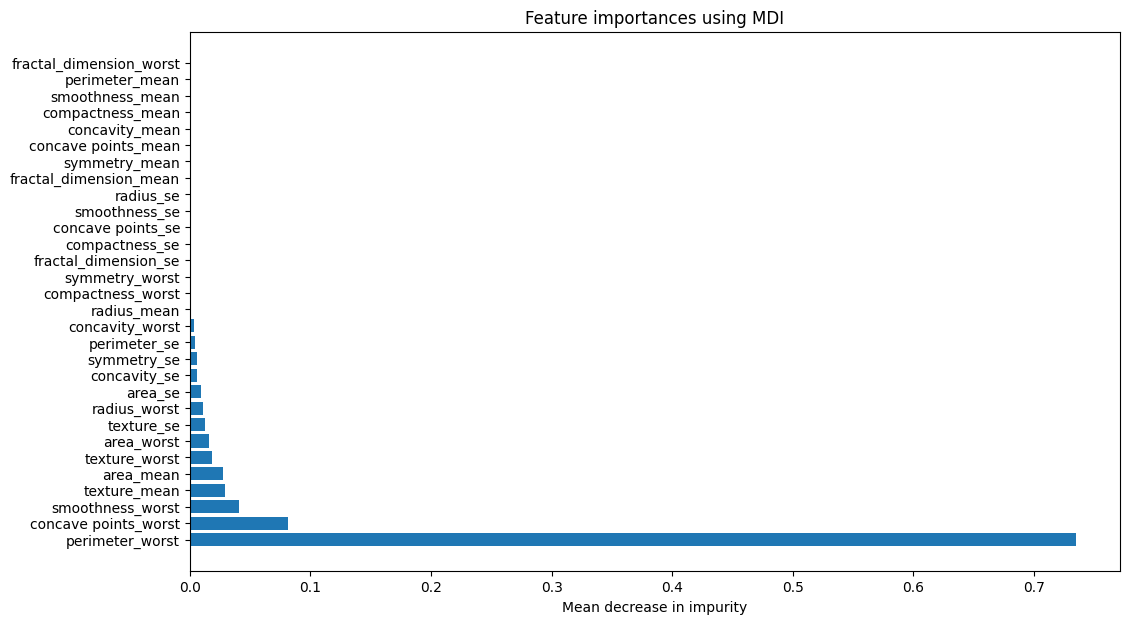

In [5]:
plt.figure(figsize=(12, 7))
plt.title("Feature importances using MDI")
plt.barh(feature_importances_dt.index, feature_importances_dt.values)
plt.xlabel("Mean decrease in impurity")
plt.show()

The results are not so good with a single tree. The method becomes more robust if we use an ensemble:

In [6]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000,
                            random_state=42).fit(X_train, y_train)

In [9]:
std_fis_rf = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
feature_importances_rf = pd.Series(rf.feature_importances_, index=rf.feature_names_in_).sort_values(ascending=False)
top10_rf_fi = feature_importances_rf[:10].index
top10_rf_fi

Index(['perimeter_worst', 'area_worst', 'concave points_worst', 'radius_worst',
       'concave points_mean', 'radius_mean', 'perimeter_mean',
       'concavity_mean', 'area_mean', 'area_se'],
      dtype='object')

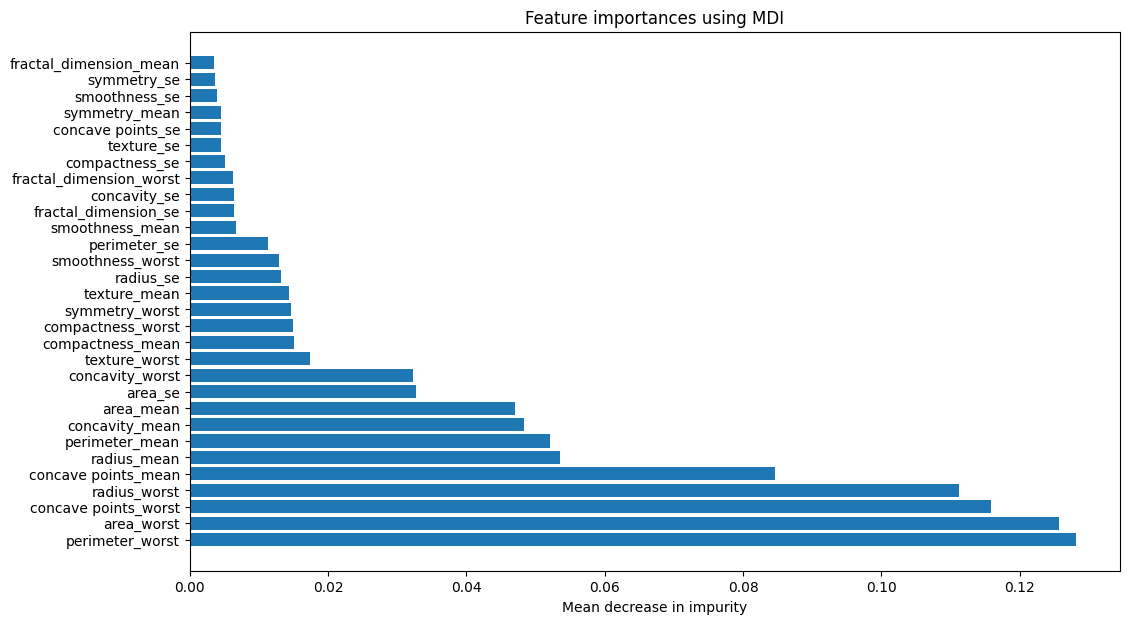

In [10]:
plt.figure(figsize=(12, 7))
plt.title("Feature importances using MDI")
plt.barh(feature_importances_rf.index, feature_importances_rf.values)
plt.xlabel("Mean decrease in impurity")
plt.show()

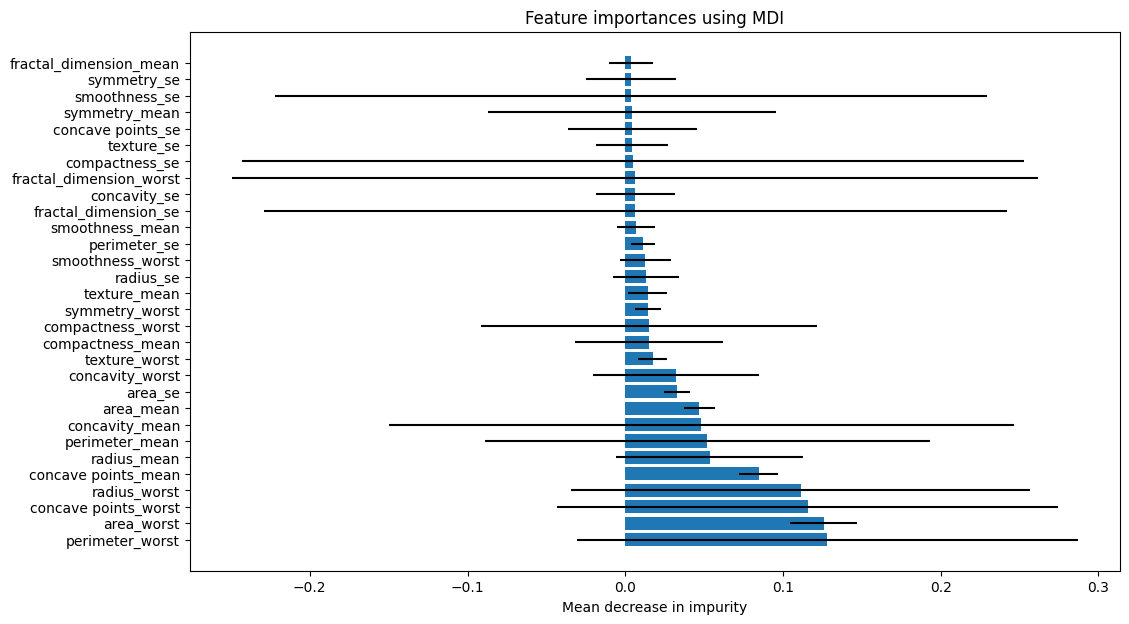

In [11]:
plt.figure(figsize=(12, 7))
plt.title("Feature importances using MDI")
plt.barh(feature_importances_rf.index, feature_importances_rf.values, xerr=std_fis_rf)
plt.xlabel("Mean decrease in impurity")
plt.show()

In [12]:
top10_dt

perimeter_worst         0.734427
concave points_worst    0.081116
smoothness_worst        0.040833
texture_mean            0.029151
area_mean               0.027148
texture_worst           0.018744
area_worst              0.015606
texture_se              0.012521
radius_worst            0.011269
area_se                 0.009278
dtype: float64

In [13]:
top10_rf_fi

Index(['perimeter_worst', 'area_worst', 'concave points_worst', 'radius_worst',
       'concave points_mean', 'radius_mean', 'perimeter_mean',
       'concavity_mean', 'area_mean', 'area_se'],
      dtype='object')

In [14]:
[x for x in top10_rf_fi if x not in top10_dt]

['concave points_mean', 'radius_mean', 'perimeter_mean', 'concavity_mean']

In [15]:
[x for x in top10_rf_fi if x in top10_dt]

['perimeter_worst',
 'area_worst',
 'concave points_worst',
 'radius_worst',
 'area_mean',
 'area_se']

The variation is huge, precisely due to the unwanted bias that is introduced by MDI.

## `permutation_importance()`, based on feature permutation

In this method, we use the `sklearn.inspection.permutation_importance()` function, which will create permutations of the features, keeping a record of a score, and how it is affected when one feature or another is eliminated. By performing several permutations, this method is more costly, but it has the advantage of eliminating the bias that high cardinality features carry with the impurity-based method.

For more details on the method, [click here](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance).

> Observation: although we have illustrated permutation importance with the decision tree, in reality this is a method that can be used with any estimator.

In [16]:
dt = DecisionTreeClassifier().fit(X_train, y_train)

In [17]:
from sklearn.inspection import permutation_importance

result_perm = permutation_importance(dt, X_train, y_train, n_repeats=20, random_state=42, n_jobs=-1)

In [19]:
data = {"importance": result_perm.importances_mean,
        "std" : result_perm.importances_std}

df_fi_perm = pd.DataFrame(data, index=dt.feature_names_in_).sort_values("importance", ascending=False)
df_fi_perm.head()

,importance,std
area_mean,0.124945,0.008520
area_se,0.101648,0.009501
perimeter_worst,0.099341,0.013469
concave points_worst,0.077582,0.010814
smoothness_worst,0.045934,0.007118


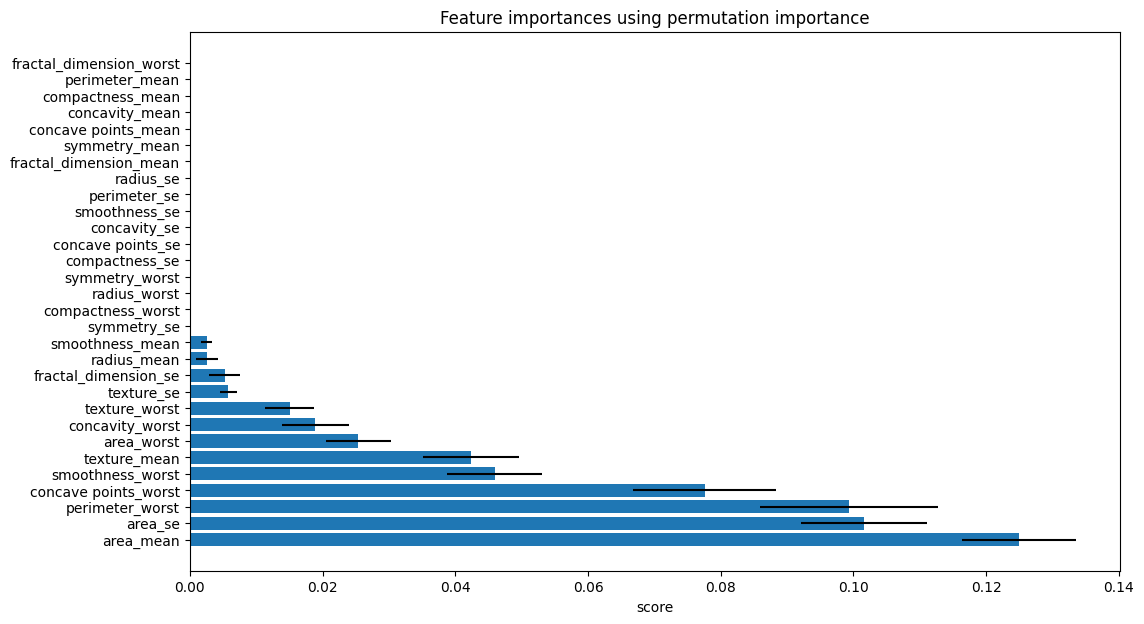

In [20]:
plt.figure(figsize=(12, 7))
plt.title("Feature importances using permutation importance")
plt.barh(df_fi_perm.index, df_fi_perm["importance"], xerr=df_fi_perm["std"])
plt.xlabel("score")
plt.show()

In [21]:
top10_dt

perimeter_worst         0.734427
concave points_worst    0.081116
smoothness_worst        0.040833
texture_mean            0.029151
area_mean               0.027148
texture_worst           0.018744
area_worst              0.015606
texture_se              0.012521
radius_worst            0.011269
area_se                 0.009278
dtype: float64

In [22]:
top10_rf_fi

Index(['perimeter_worst', 'area_worst', 'concave points_worst', 'radius_worst',
       'concave points_mean', 'radius_mean', 'perimeter_mean',
       'concavity_mean', 'area_mean', 'area_se'],
      dtype='object')

In [23]:
top10_perm = df_fi_perm[:10].index
top10_perm

Index(['area_mean', 'area_se', 'perimeter_worst', 'concave points_worst',
       'smoothness_worst', 'texture_mean', 'area_worst', 'concavity_worst',
       'texture_worst', 'texture_se'],
      dtype='object')

In [24]:
[x for x in top10_perm if x not in top10_dt]

['concavity_worst']

In [25]:
[x for x in top10_perm if x not in top10_rf_fi]

['smoothness_worst',
 'texture_mean',
 'concavity_worst',
 'texture_worst',
 'texture_se']

From here, the next step would be to train a model normally (pipeline, gridsearch, etc), but only with these selected features (ideally, a combination of these heuristics).

# Recursive Feature Elimination - RFE

The RFE is a method that uses an estimator capable of assigning an **importance** score to each of the features.

> For instance, we can look at the coefficients of a linear model (`coef_`) or the feature importance scores (`feature_importances_`)

The method then recursively considers **smaller and smaller subsets of features**, as follows:

- the estimator is trained initially with all features
- the importance of each of the features is calculated
- the less important features are removed from the feature set
- the process starts over, until the desired number of features is reached

This way, we have two important hyperparameters in the [RFE](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) class:

- `estimator`: it is the estimator that will provide the feature importance scores
- `n_features_to_select`: amount of features that the final subset will have

In practice, we can use a gridsearch to optimize these two hyperparameters, or use the [RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html) class, which automatically determines the best number of features.

In [26]:
from sklearn.feature_selection import RFE

rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10).fit(X_train, y_train)

In [30]:
top10_rfe = X_train.columns[rfe.support_]
top10_rfe

Index(['texture_mean', 'area_mean', 'area_se', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst'],
      dtype='object')

In [31]:
top10_dt

perimeter_worst         0.734427
concave points_worst    0.081116
smoothness_worst        0.040833
texture_mean            0.029151
area_mean               0.027148
texture_worst           0.018744
area_worst              0.015606
texture_se              0.012521
radius_worst            0.011269
area_se                 0.009278
dtype: float64

In [32]:
[features for features in top10_rfe if features not in top10_dt]

['compactness_worst', 'concavity_worst']

In [34]:
[features for features in top10_dt if features in top10_rfe]

[]


Let's see how [RFE-CV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html) works:

In [35]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

splitter = StratifiedKFold(n_splits=5)

rfecv = RFECV(estimator=DecisionTreeClassifier(),
              scoring="f1_weighted",
              cv=splitter).fit(X_train, y_train)

In [38]:
X_train.columns[rfecv.support_]

Index(['texture_mean', 'perimeter_worst', 'smoothness_worst',
       'concave points_worst'],
      dtype='object')